In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import shutil
import numpy as np
import random

from PIL import Image

# EDA

In [2]:
# Metadata para ordenar el entrenamiento
metadata_path = 'datasets\Labeled Stomatal Images.csv'
metadata = pd.read_csv(metadata_path)

In [3]:
metadata.head()

,FileName,Species,ScientificName,Magnification,Witdh,Heigth,Resolution
0,STMHD0001,Nuttall oak,Quercus texana Buckley,100,1024,768,118
1,STMHD0002,Nuttall oak,Quercus texana Buckley,100,1024,768,118
2,STMHD0003,Nuttall oak,Quercus texana Buckley,100,1024,768,118
3,STMHD0004,Nuttall oak,Quercus texana Buckley,100,1024,768,118
4,STMHD0005,Nuttall oak,Quercus texana Buckley,100,1024,768,118


In [4]:
# Calcular el número total de imágenes
total_images = len(metadata)

# Calcular la media y desviación estándar de Width y Height
mean_width = metadata['Witdh'].mean()
std_width = metadata['Witdh'].std()
mean_height = metadata['Heigth'].mean()
std_height = metadata['Heigth'].std()

# Número de especies únicas
unique_species = metadata['Species'].nunique()

# Frecuencia de cada especie
species_frequency = metadata['Species'].value_counts()

# Frecuencia de resoluciones (Width x Height)
resolution_frequency = metadata.groupby(['Witdh', 'Heigth']).size()

# Media de la magnificación
mean_magnification = metadata['Magnification'].mean()

# Frecuencia de magnificación
magnification_frequency = metadata['Magnification'].value_counts()

# Print results
print("Total de imágenes:", total_images)
print("Witdh promedio:", mean_width, "Desviación estándar del ancho:", std_width)
print("Heigth promedio:", mean_height, "Desviación estándar de la altura:", std_height)
print("Número de especies únicas:", unique_species)
print("Frecuencia de cada especie:", species_frequency)
print("Frecuencia de resoluciones:", resolution_frequency)
print("Magnificación promedio:", mean_magnification)
print("Frecuencia de magnificaciones:", magnification_frequency)


Total de imágenes: 10715
Witdh promedio: 1407.319085394307 Desviación estándar del ancho: 495.5886844096622
Heigth promedio: 1055.4893140457302 Desviación estándar de la altura: 371.6915133072467
Número de especies únicas: 18
Frecuencia de cada especie: Species
Poplar                3068
Nuttall oak           2975
Shumard oak           1612
Water oak              653
Willow oak             568
Cherrybark oak         286
Winged elm             205
Ash                    200
Post oak               196
American elm           185
Leatherwood            130
Swamp chestnut oak     129
American Holly         100
Red maple              100
Shagbark hickory        91
Deerberry               85
Willow                  82
Black gum               50
Name: count, dtype: int64
Frecuencia de resoluciones: Witdh  Heigth
1024   768       6704
2048   1536      4011
dtype: int64
Magnificación promedio: 270.32197853476436
Frecuencia de magnificaciones: Magnification
200    5740
400    4170
100     805
Nam

In [5]:
# Ruta al directorio donde están almacenados tus archivos .txt
path = 'datasets/train/labels'

# Lista para almacenar el número de líneas de cada archivo
line_counts = []

# Recorrer cada archivo en el directorio
for filename in os.listdir(path):
    if filename.endswith('.txt'):  # Asegurarse de procesar solo archivos .txt
        with open(os.path.join(path, filename), 'r') as file:
            lines = file.readlines()
            line_counts.append(len(lines))  # Añadir el número de líneas

# Calcular la media y la desviación estándar de line_counts
if line_counts:
    mean_boxes = np.mean(line_counts)
    variance = np.var(line_counts)
    std_dev = variance ** 0.5
    print(f'Total de bounding boxes: {sum(line_counts)}')
    print(f'Media de bounding boxes por imagen: {mean_boxes}')
    print(f'Desviación estándar de bounding boxes por imagen: {std_dev}')
else:
    print("No se encontraron archivos .txt en el directorio.")

Total de bounding boxes: 170330
Media de bounding boxes por imagen: 79.51914098972922
Desviación estándar de bounding boxes por imagen: 68.71039888305309


# Preprocesamiento

In [6]:
#Mediciones 1 plant-out
def onePlantOut(plant_name):
  main_folder = 'datasets'

  train_images_folder = os.path.join(main_folder, 'train/images')
  train_labels_folder = os.path.join(main_folder, 'train/labels')
  val_images_folder = os.path.join(main_folder, 'val/images')
  val_labels_folder = os.path.join(main_folder, 'val/labels')

  folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
  for folder in folders:
      if not os.path.exists(folder):
          os.makedirs(folder)

  # Seleccionar la planta a medir su rendimiento
  plant = plant_name
  trainFiles = metadata[metadata['Species'] != plant]['FileName'].tolist()
  valFiles = metadata[metadata['Species'] == plant]['FileName'].tolist()

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in trainFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))

  for folder in folders:
    for file in os.listdir(folder):
      if file.split(".")[0] in valFiles:
        if file.endswith(".jpg"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
        elif file.endswith(".txt"):
          shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))

def holdOut(random_seed = 42, test_size = 0.2):
    random.seed(random_seed)
    main_folder = 'datasets'

    train_images_folder = os.path.join(main_folder, 'train/images')
    train_labels_folder = os.path.join(main_folder, 'train/labels')
    val_images_folder = os.path.join(main_folder, 'val/images')
    val_labels_folder = os.path.join(main_folder, 'val/labels')

    folders = [train_images_folder, train_labels_folder, val_images_folder, val_labels_folder]

  # Sino existen los directorios
    for folder in folders:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # Obtener todos los archivos de la columna 'FileName'
    all_files = metadata['FileName'].tolist()

    # Mezclar aleatoriamente los archivos
    random.shuffle(all_files,)

    split_idx = int((1-test_size) * len(all_files))
    trainFiles = all_files[:split_idx]
    valFiles = all_files[split_idx:]

    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in trainFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'train/labels', file))
    
    for folder in folders:
        for file in os.listdir(folder):
            if file.split(".")[0] in valFiles:
                if file.endswith(".jpg"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/images', file))
                elif file.endswith(".txt"):
                    shutil.move(os.path.join(folder, file), os.path.join(main_folder, 'val/labels', file))



In [7]:
holdOut(random_seed = 42, test_size = 0.2)
# onePlantOut("Nuttall oak")

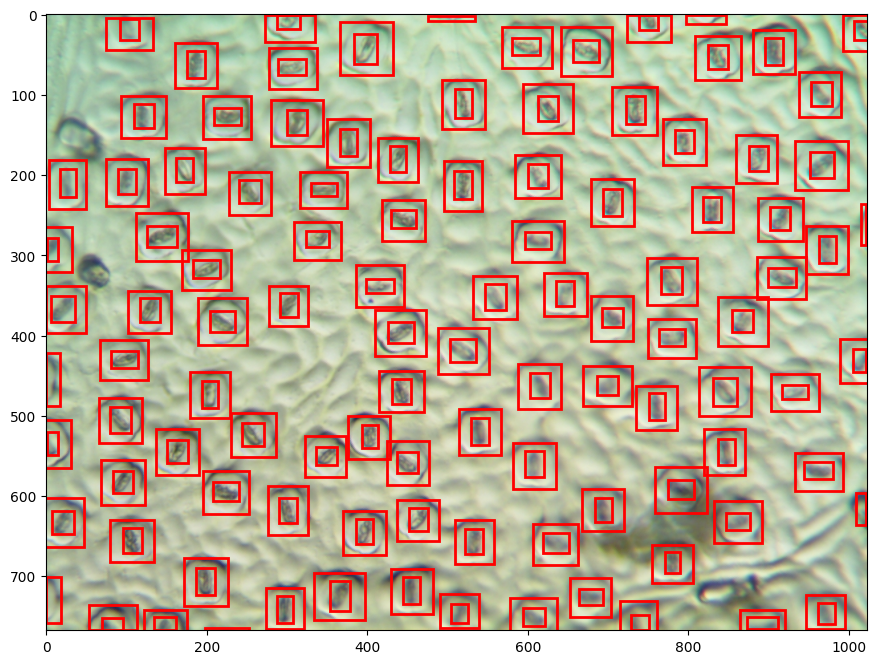

In [8]:
PATH_images = "datasets/train/images"
PATH_labels = "datasets/train/labels"
plant_type = '/STMHD'
number = "0005"
image_path = f"{PATH_images}{plant_type}{number}.jpg"
txt_path = f"{PATH_labels}{plant_type}{number}.txt"

def show_image(image_path, txt_path):
    img = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Leer y mostrar el contenido del archivo .txt
    with open(txt_path, 'r') as file:
        annotations = file.readlines()

    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation.split())
        x = (x_center - width / 2) * img.shape[1]
        y = (y_center - height / 2) * img.shape[0]
        w = width * img.shape[1]
        h = height * img.shape[0]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
show_image(image_path, txt_path)

# YOLO

In [ ]:
from ultralytics import YOLO

modelSimple = YOLO('Modelos\yolov8\yolov8n.pt')
modelAdjust = YOLO('Modelos\yolov8\yolov8n.pt')

# Entrenar el modelo
modelSimple.train(data='YOLO8INFO.yaml', epochs=30, imgsz=640, batch=16, device=0) #Simple
modelSimple.save('Modelos\yolov8\HoldOutSimpleYolov8n.pt')

New https://pypi.org/project/ultralytics/8.3.4 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.100  Python-3.10.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: task=detect, mode=train, model=Modelos\yolov8\yolov8n.pt, data=YOLO8INFO.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

100%|██████████| 6.25M/6.25M [00:00<00:00, 8.64MB/s]


AMP: checks passed 


train: Scanning C:\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\train\labels... 2142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2142/2142 [00:01<00:00, 2012.30it/s]


train: New cache created: C:\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\train\labels.cache


val: Scanning C:\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels... 8573 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8573/8573 [00:10<00:00, 807.53it/s] 


val: New cache created: C:\Escritorio\Stomatal-Density-with-Deep-Learning\datasets\val\labels.cache

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train8
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.13G      1.634      3.516      1.236       2126        640:  19%|█▉        | 26/134 [00:06<00:24,  4.49it/s]

In [ ]:
# Entrenar el modelo con hiperparámetros ajustados
modelAdjust.train(
    data='YOLO8INFO.yaml',     # Archivo de configuración de los datos
    epochs=50,                 # Aumentar el número de épocas para una mayor convergencia
    imgsz=640,                 # Tamaño de las imágenes para mejorar la precisión
    batch=32,                  # Tamaño del lote mayor para un entrenamiento más rápido (ajustar según la GPU)
    device=0,                  # Especificar el dispositivo GPU
    lr0=0.01,                  # Tasa de aprendizaje inicial más alta
    lrf=0.2,                   # Factor de reducción de la tasa de aprendizaje
    momentum=0.937,            # Momento optimizado para estabilizar el entrenamiento
    weight_decay=0.0005,       # Decaimiento del peso para evitar el sobreajuste
    warmup_epochs=3.0,         # Épocas de calentamiento para estabilizar el modelo al inicio
    warmup_momentum=0.8,       # Momento de calentamiento
    warmup_bias_lr=0.1,        # Tasa de aprendizaje inicial para el sesgo
    box=0.05,                  # Ponderación de la pérdida de la caja
    cls=0.5,                   # Ponderación de la pérdida de clasificación
    dfl=1.0,                   # Ponderación de la pérdida de distribución de la etiqueta
    hsv_h=0.015,               # Augmentación de color - ajuste de tono
    hsv_s=0.7,                 # Augmentación de color - ajuste de saturación
    hsv_v=0.4,                 # Augmentación de color - ajuste de valor
    degrees=0.0,               # Augmentación - rotación de la imagen
    translate=0.1,             # Augmentación - traducción de la imagen
    scale=0.5,                 # Augmentación - escalado de la imagen
    shear=0.0,                 # Augmentación - cizallamiento
    flipud=0.0,                # Volteo vertical (no comúnmente usado)
    fliplr=0.5,                # Volteo horizontal (común para imágenes de objetos)
    mosaic=1.0,                # Habilitar la mezcla de mosaico (aumenta el conjunto de datos)
    mixup=0.2,                 # Habilitar mixup para mezclar las imágenes
    label_smoothing=0.1        # Suavización de etiquetas para evitar sobreajuste
)
modelAdjust.save('HoldOutAdjustYolov8n.pt')

In [154]:
def plot_detections(results):
    img_rgb = cv2.cvtColor(results.orig_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img_rgb)
    for box, score in zip(results.boxes.xyxy, results.boxes.conf):
        x1, y1, x2, y2 = box
        # Coordenadas deben ser ints
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Mostrar el score como etiqueta en la esquina superior izquierda de la caja
        label = f"{score:.2f}"  # Formatear el score a 2 decimales
        ax.text(x1, y1, label, color='white', fontsize=5, verticalalignment='top', bbox={'color': 'r', 'pad': 0})
        
    plt.show()


image 1/1 c:\Escritorio\Semestre 10\Capstone\datasets\val\images\STMHD0001.jpg: 480x640 87 stoma1s, 80 stoma2s, 71.6ms
Speed: 6.0ms preprocess, 71.6ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


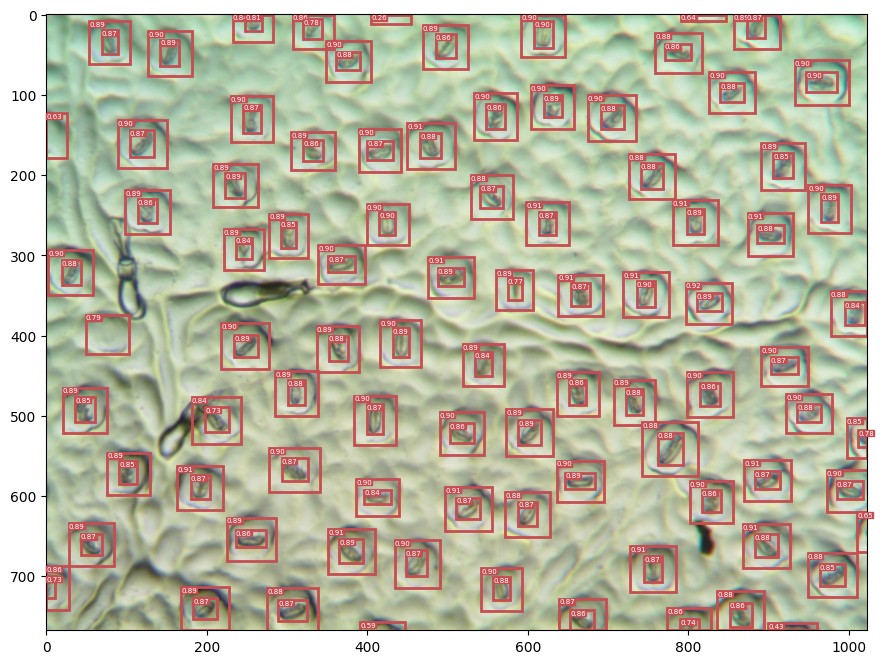

In [155]:
image_path = "datasets/val/images/STMHD0001.jpg"

results = model.predict(image_path)[0]

plot_detections(results)